In [124]:
from skimage import io
from skimage import img_as_float
import cv2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [159]:
def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0., dtype =0)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (12,6))
    fig.add_subplot(1,2,1)
    plt.imshow(mask_overlay(img, mask))
    fig.add_subplot(1,2,2)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
    
    
def rle_decode(mask_rle, shape=(101,101)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


In [6]:
import os
os.chdir('../')

In [51]:
import pandas as pd
import numpy as np

In [765]:
#test_df= pd.read_csv('sub_70.csv')
test_df= pd.read_csv('submission_70_20_10_new.csv')
#test_df= pd.read_csv('submission_858.csv')
#test_df= pd.read_csv('submission_855.csv')
#test_df= pd.read_csv('submission_optimistic.csv')
test_df['filename_path'] = 'data/test/images/' + test_df['id'] + '.png'
test_df['is_train']= False
train_df = pd.read_csv('data/train.csv')

train_df['filename_path'] = 'data/train/images/' + train_df['filename']
train_df.drop(columns = ['class'], inplace= True)
train_df.drop(columns = ['Unnamed: 0','Unnamed: 0.1'], inplace= True)
train_df['is_train']= True
df = pd.concat([train_df,test_df], axis = 0)
df.fillna('', inplace = True)
df.index = df['id']
print("ok")

ok


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [581]:
df.head()

filename                     filename_path          id  \
id                                                                         
575d24d81d  575d24d81d.png  data/train/images/575d24d81d.png  575d24d81d   
a266a2a9df  a266a2a9df.png  data/train/images/a266a2a9df.png  a266a2a9df   
75efad62c1  75efad62c1.png  data/train/images/75efad62c1.png  75efad62c1   
34e51dba6a  34e51dba6a.png  data/train/images/34e51dba6a.png  34e51dba6a   
4875705fb0  4875705fb0.png  data/train/images/4875705fb0.png  4875705fb0   

            is_train                                           rle_mask  
id                                                                       
575d24d81d      True                                                     
a266a2a9df      True                                          5051 5151  
75efad62c1      True  9 93 109 94 210 94 310 95 411 95 511 96 612 96...  
34e51dba6a      True  48 54 149 54 251 53 353 52 455 51 557 50 659 4...  
4875705fb0      True  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...

In [582]:
df.shape

(22000, 5)

In [27]:
import matplotlib.pyplot as plt

In [563]:
def show_m(mask_df, show_mask = True):
    mask_df.fillna('NAN', inplace = True)
    max_x = mask_df.shape[1]
    max_y = mask_df.shape[0]
    fig, ax = plt.subplots(max_y, max_x, figsize=(max_x*2, max_y*2))
    for i in range(max_y):
        for j in range(max_x):
            ax[i,j].axis('off')
            image_id = mask_df.iloc[i,j]
            if image_id != 'NAN': 
                fname = df.loc[df['id'] == image_id,"filename_path"].item()
                image = io.imread(fname)
                rle = df.loc[df['id'] == image_id]['rle_mask'].item()
                if rle != '' and show_mask:
                    mask = rle_decode(rle) * 255
                    image = mask_overlay(image, mask, color=(0, 1, 0))
            
                if 'train' in fname:
                    text_ = 'TRN'
                    color_ = (0,0,255)
                else:
                    text_ = 'TST'
                    color_ = (255,0,0)
                cv2.putText(image,text_,(5,90),color = color_, fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5) 
                l_corr = str(neib_df_full.loc[image_id, "left_corr"])
                r_corr = str(neib_df_full.loc[image_id, "right_corr"])
                t_corr = str(neib_df_full.loc[image_id, "top_corr"])
                b_corr = str(neib_df_full.loc[image_id, "bottom_corr"])
                cv2.putText(image,l_corr,(5,50),color = color_, fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.35) 
                cv2.putText(image,r_corr,(80,50),color = color_, fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.35)
                cv2.putText(image,t_corr,(50,15),color = color_, fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.35) 
                cv2.putText(image,b_corr,(45,90),color = color_, fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.35) 
            else:
                image = np.zeros((101,101,3))

                

            ax[i,j].imshow(image, cmap='Greys')


    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

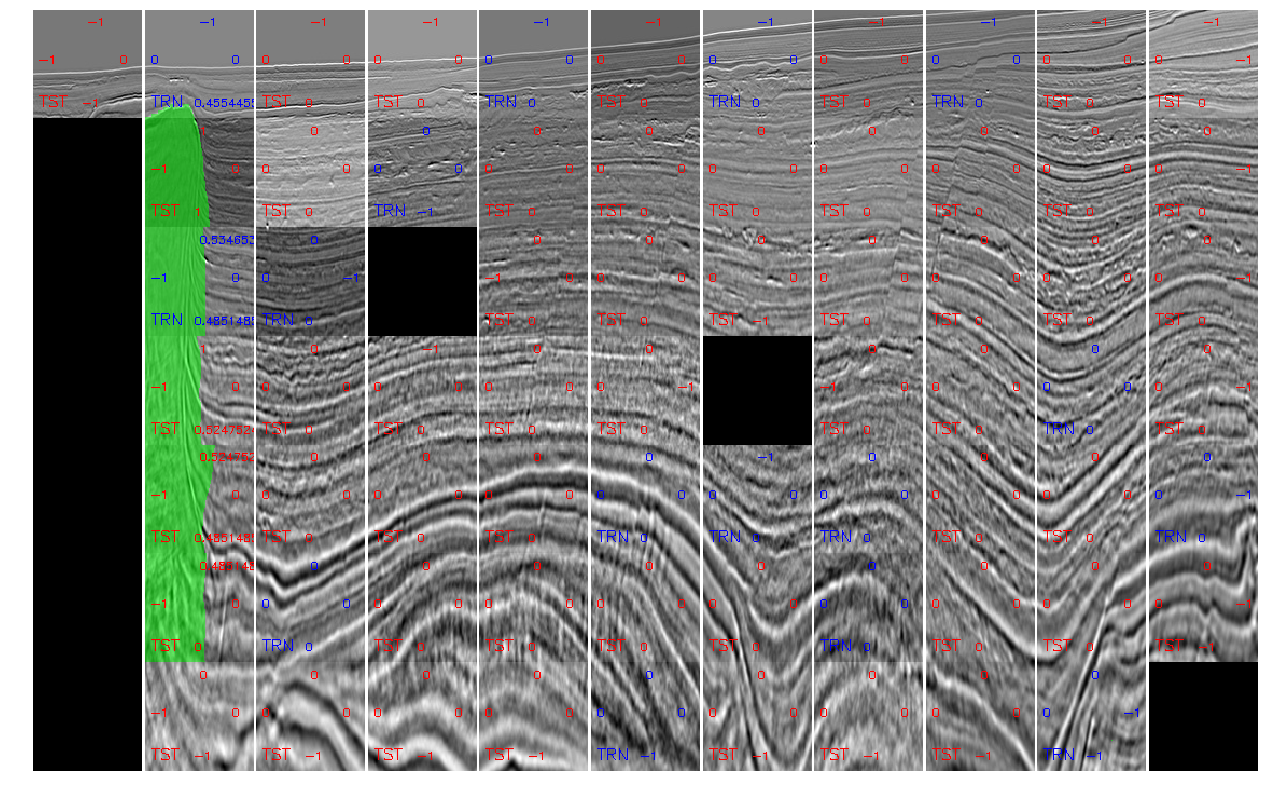

In [766]:
t = pd.read_csv('mos_numpy/mosaic_4.csv', header = None)
show_m(t, show_mask = True)

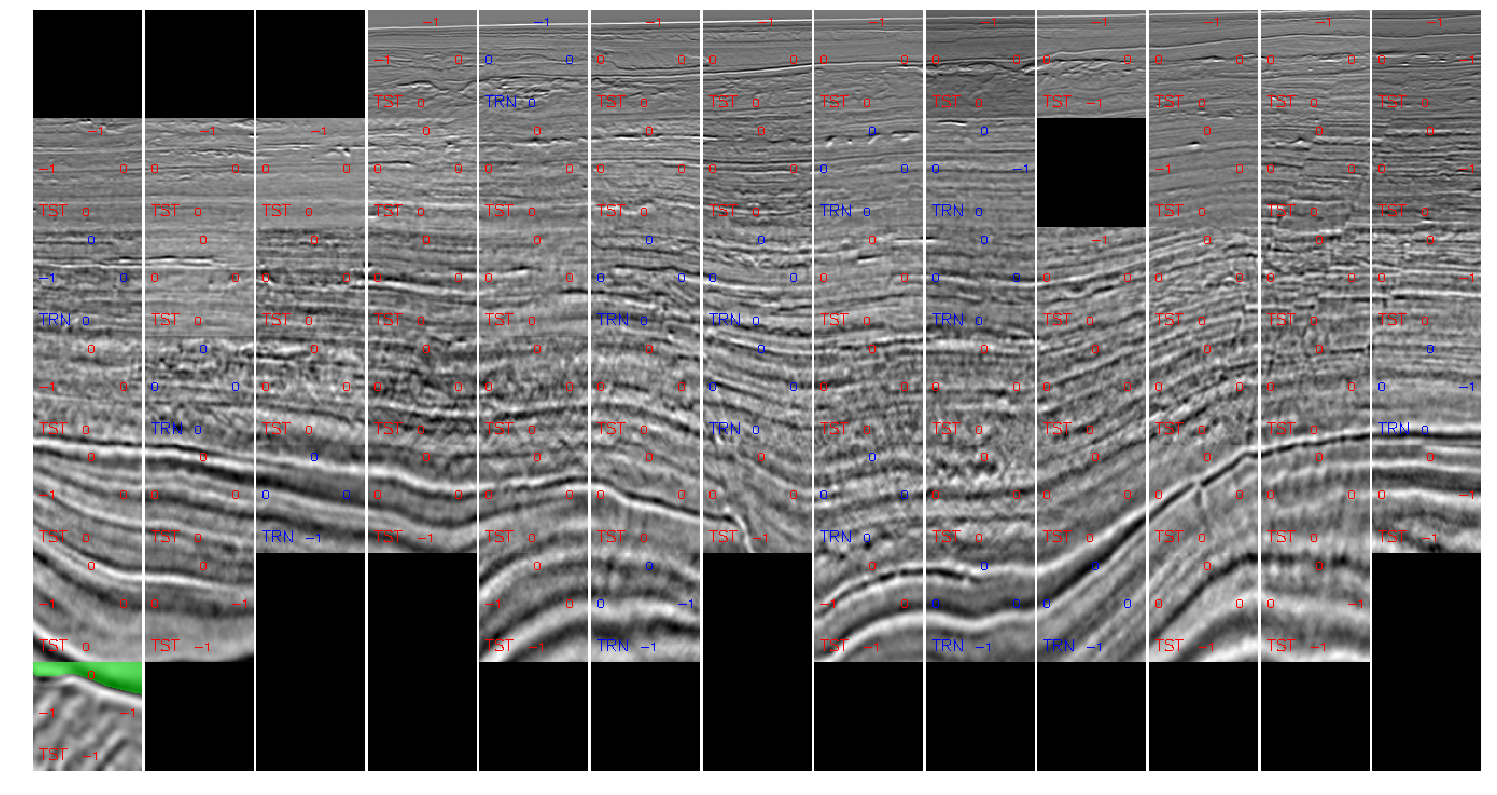

In [762]:
t = pd.read_csv('mos_numpy/mosaic_100.csv', header = None)
show_m(t, show_mask = True)

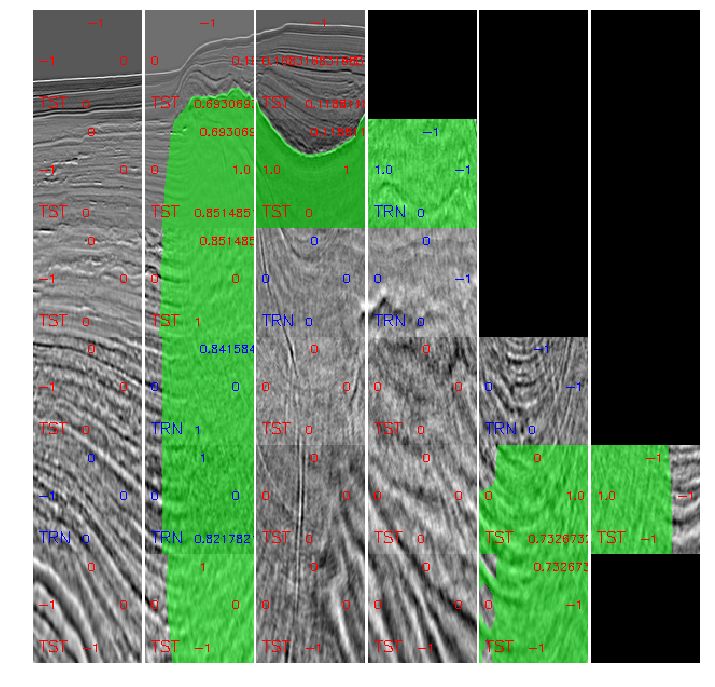

In [767]:
t = pd.read_csv('mos_numpy/mosaic_101.csv', header = None)
show_m(t, show_mask = True)

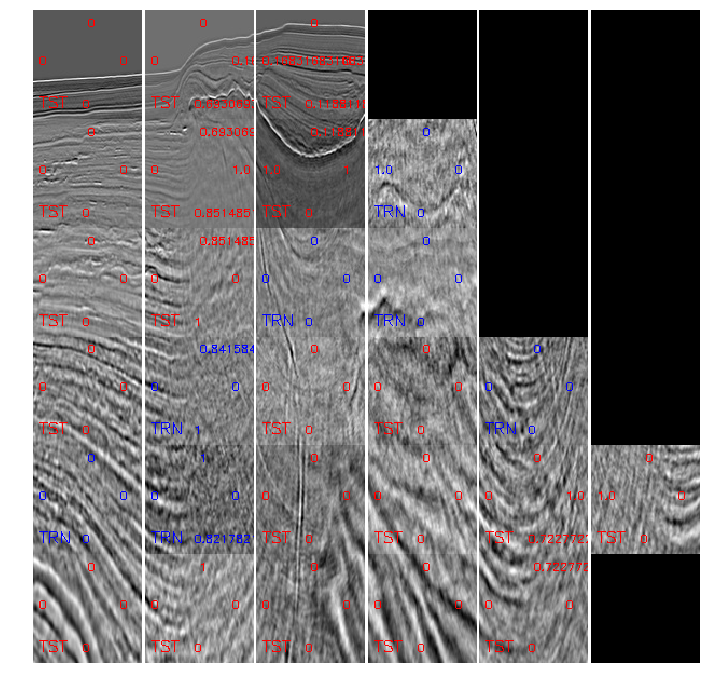

In [656]:
t = pd.read_csv('mos_numpy/mosaic_101.csv', header = None)
show_m(t, show_mask = False)

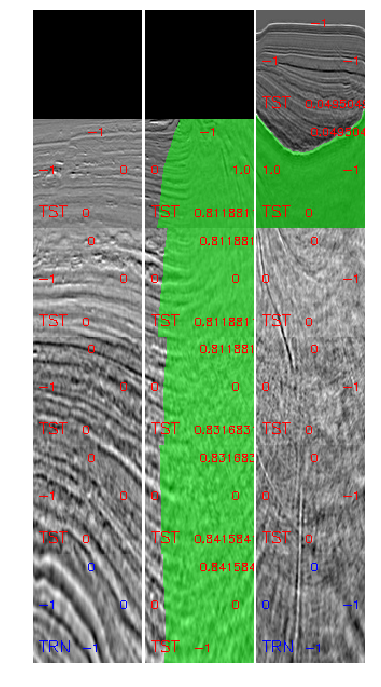

In [768]:
t = pd.read_csv('mos_numpy/mosaic_103.csv', header = None)
show_m(t, show_mask = True)

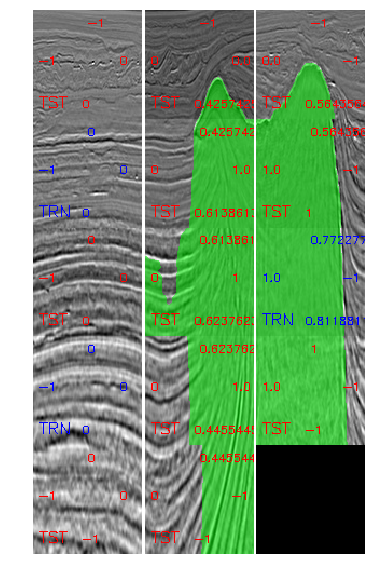

In [769]:
t = pd.read_csv('mos_numpy/mosaic_105.csv', header = None)
show_m(t, show_mask = True)

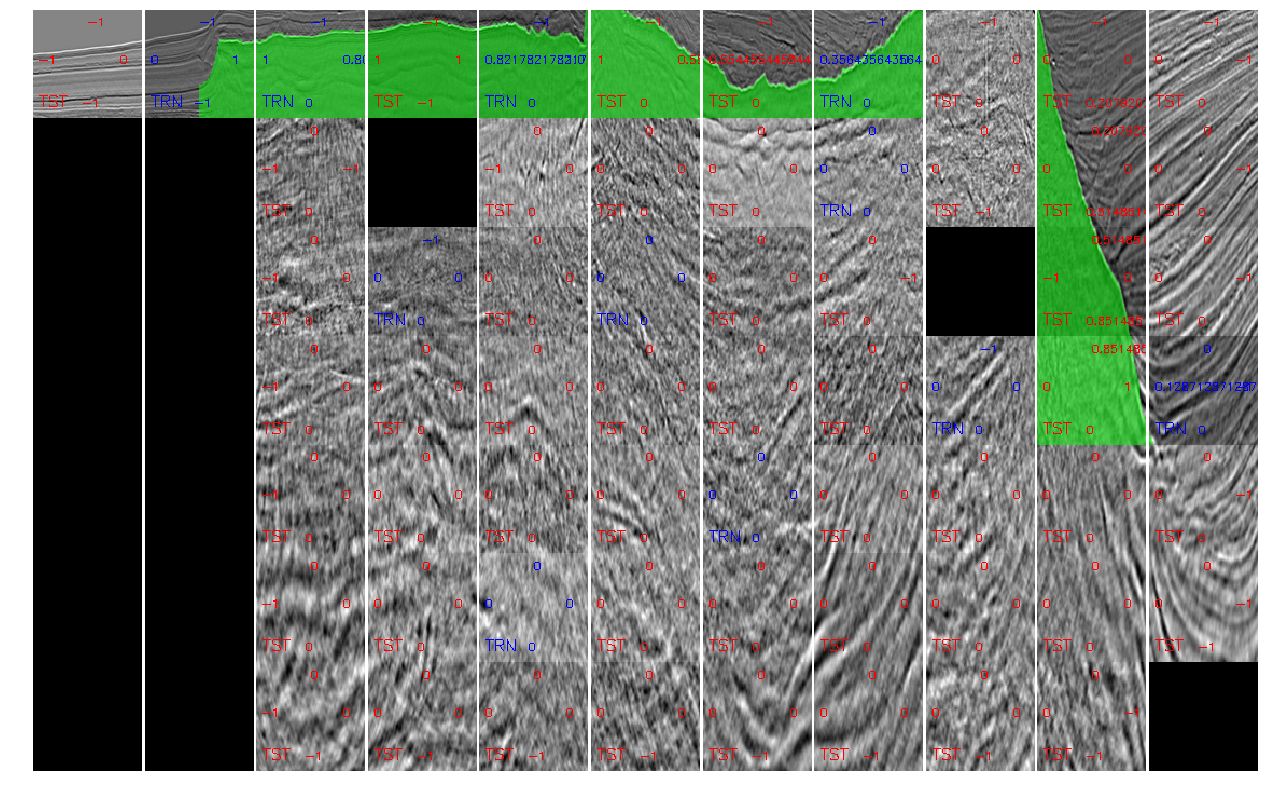

In [723]:
t = pd.read_csv('mos_numpy/mosaic_106.csv', header = None)
show_m(t, show_mask = True)

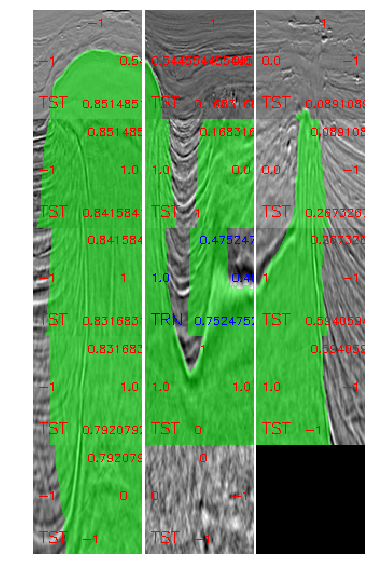

In [764]:
t = pd.read_csv('mos_numpy/mosaic_107.csv', header = None)
show_m(t, show_mask = True)

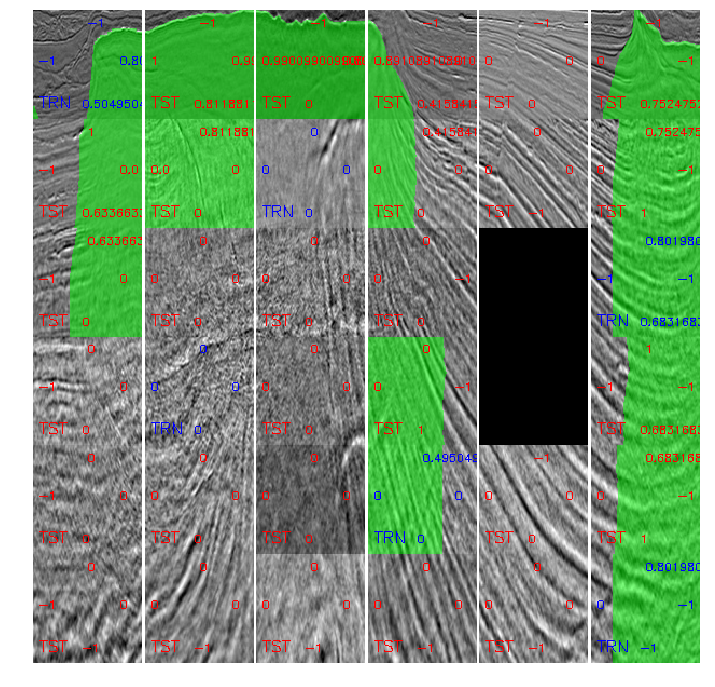

In [725]:
t = pd.read_csv('mos_numpy/mosaic_108.csv', header = None)
show_m(t, show_mask = True)

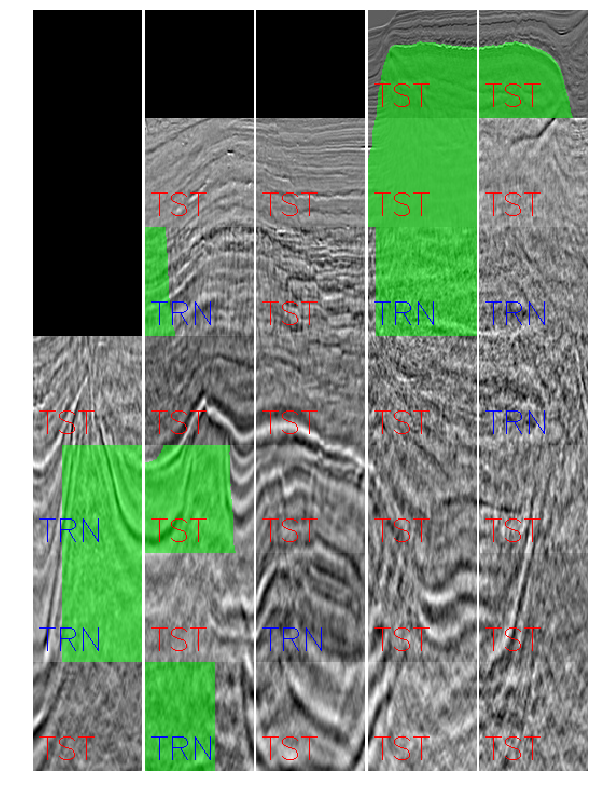

In [252]:
t = pd.read_csv('mos_numpy/mosaic_109.csv', header = None)
show_m(t, show_mask = True)

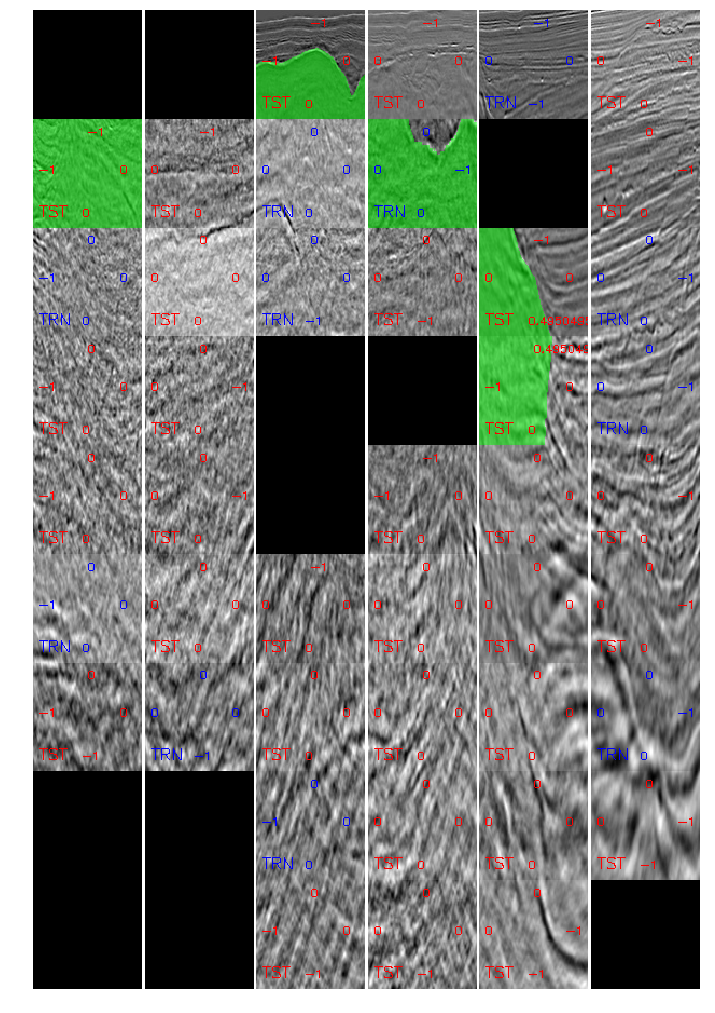

In [726]:
t = pd.read_csv('mos_numpy/mosaic_111.csv', header = None)
show_m(t, show_mask = True)

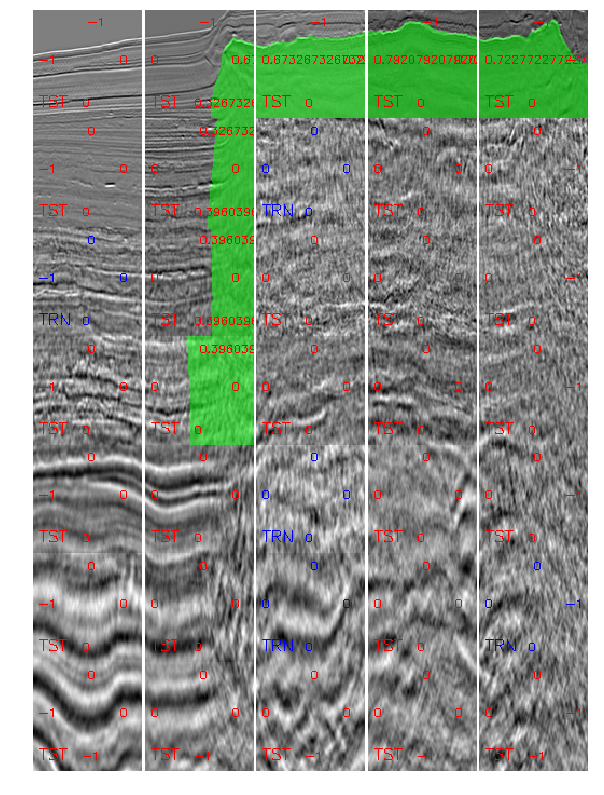

In [727]:
t = pd.read_csv('mos_numpy/mosaic_113.csv', header = None)
show_m(t, show_mask = True)

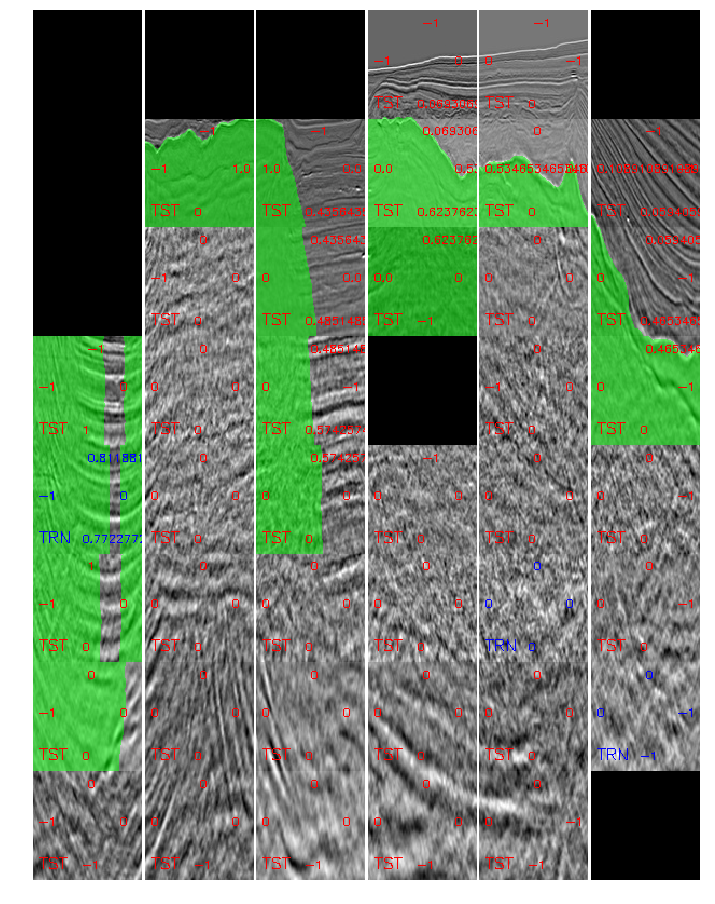

In [728]:
t = pd.read_csv('mos_numpy/mosaic_116.csv', header = None)
show_m(t, show_mask = True)

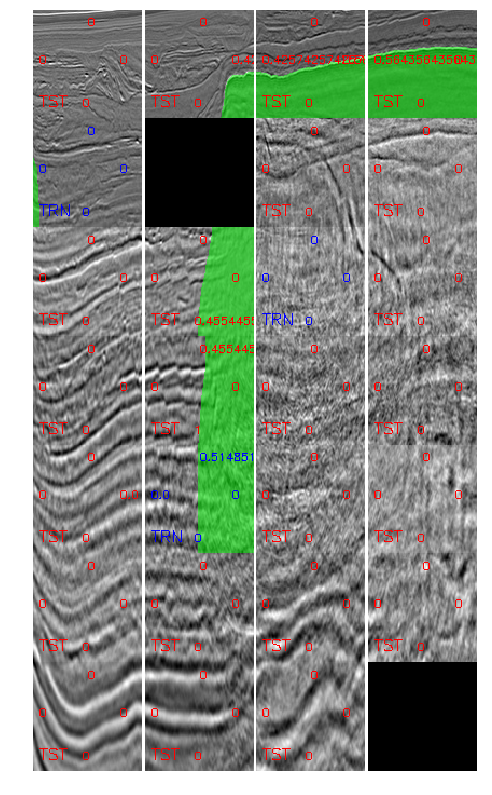

In [666]:
t = pd.read_csv('mos_numpy/mosaic_118.csv', header = None)
show_m(t, show_mask = True)

In [752]:
def fill_neib_df(mos_df,t):
    neib_df = pd.DataFrame(columns = ["left","right","top","bottom","left_corr", "right_corr","top_corr","bottom_corr","t"])
    max_r = mos_df.shape[0]
    max_c = mos_df.shape[1]
    for r in range(max_r):
        for c in range(max_c):
            id_ = mos_df.iloc[r, c]
            if pd.isna(id_):  continue
            if id_ in neib_df_full: print("Dublicate {}".format(id_))
            
            left_n, top_n, right_n, bottom_n = np.NAN, np.NAN, np.NAN, np.NAN

            if c!=0:
                left_n=mos_df.iloc[r, c-1]

            if r!=0:
                top_n = mos_df.iloc[r-1, c]

            if c!= max_c-1:
                right_n = mos_df.iloc[r, c+1]

            if r!= max_r-1:
                bottom_n = mos_df.iloc[r+1, c]

            dict_a = {'left':left_n,'right':right_n,'top':top_n,'bottom':bottom_n,'t': t}
            neib_df = neib_df.append(pd.Series(dict_a, name = id_, dtype = 'object'))
            
    neib_df.replace('NAN', np.NAN, inplace = True)
    return neib_df

In [481]:
a1 = np.array([0,0,1,1,0,0])
a2 = np.array([1,1,1,1,1,1])
#np.abs(np.corrcoef(a1,a2, rowvar = False))
a1 & a2

array([0, 0, 1, 1, 0, 0], dtype=int32)

In [753]:
def get_corr(id_1, id_2, side):
    
    rle_1 = df.loc[id_1,'rle_mask']
    rle_2 = df.loc[id_2,'rle_mask']
    
    if rle_1 !='' and rle_2 != '':
        mask1 = rle_decode(rle_1)
        mask2 = rle_decode(rle_2)
        if side =='left':
            d1 = mask1[:,:2].mean(axis = 1)
            d2 = mask2[:,-2:].mean(axis = 1)
        
        if side =='right':
            d1 = mask1[:,-2:].mean(axis = 1)
            d2 = mask2[:,:2].mean(axis = 1)

        if side =='top':
            d1 = mask1[:2,:].mean(axis = 0)
            d2 = mask2[-2:,:].mean(axis = 0)
        
        if side =='bottom':
            d1 = mask1[-2:,:].mean(axis = 0)
            d2 = mask2[:2,:].mean(axis = 0)
            
        d1 = (d1>0)
        d2 = (d2>0)
        
        #corr = np.abs(np.corrcoef(d1,d2)[0,1])
        corr = np.sum(d1 & d2) / 101
        if corr > 0.05 and df.loc[id_2,'is_train']:
            corr = 1
        
        if df.loc[id_2,'is_train'] and mask2.mean() == 0:
            corr = -1
        
        return corr    
                        
    else:
        return 0
        

In [754]:
def fill_corr(neib_df):
    for id_ in neib_df.index:
        neib_df.loc[id_, 'left_corr'] = get_corr(id_, neib_df.loc[id_,'left'],'left') if not pd.isna(neib_df.loc[id_,'left']) else -1
        neib_df.loc[id_, 'right_corr'] = get_corr(id_, neib_df.loc[id_,'right'],'right') if not pd.isna(neib_df.loc[id_,'right']) else -1
        neib_df.loc[id_, 'top_corr'] = get_corr(id_, neib_df.loc[id_,'top'],'top') if not pd.isna(neib_df.loc[id_,'top']) else -1
        neib_df.loc[id_, 'bottom_corr'] = get_corr(id_, neib_df.loc[id_,'bottom'],'bottom') if not pd.isna(neib_df.loc[id_,'bottom']) else -1
    return neib_df

In [755]:
neib_df_full =  pd.DataFrame(columns = ["left","right","top","bottom","left_corr", "right_corr","top_corr","bottom_corr","t"])
for m in range(207):
    t = pd.read_csv('mos_numpy/mosaic_{}.csv'.format(m), header = None,dtype = 'object')
    neib_df_full = neib_df_full.append(fill_neib_df(t,m))
    

In [756]:
neib_df_full = fill_corr(neib_df_full)

In [757]:
neib_df_full['max_corr'] = neib_df_full[['left_corr','right_corr','top_corr','bottom_corr']].max(axis = 1)

In [758]:
neib_df_full.head(10)

left       right         top      bottom left_corr  \
14b50d2c26         NaN  31f29ada31         NaN  0b9874fd4f        -1   
31f29ada31  14b50d2c26  26c403ce6d         NaN  476bde9dbf         0   
26c403ce6d  31f29ada31  3eef3e190f         NaN  ad068f08d1         0   
3eef3e190f  26c403ce6d         NaN         NaN  4d33311a1e         0   
b2d4c41f68         NaN  14c2834524         NaN  27838f7f46        -1   
14c2834524  b2d4c41f68  cb36e2e2ae         NaN  f27a3ca60e         0   
cb36e2e2ae  14c2834524  971ff26c0d         NaN  da324cbdde         0   
971ff26c0d  cb36e2e2ae  a0891f7e3e         NaN  d0bdfc3217         0   
a0891f7e3e  971ff26c0d         NaN         NaN  393048bc6c         0   
0b9874fd4f         NaN  476bde9dbf  14b50d2c26  eb84dfdf18        -1   

           right_corr top_corr bottom_corr  t  max_corr  
14b50d2c26          0       -1           0  0       0.0  
31f29ada31          0       -1           0  0       0.0  
26c403ce6d          0       -1           0  0       0.0  
3eef3e190f         -1       -1           0  0       0.0  
b2d4c41f68          0       -1           0  0       0.0  
14c2834524          0       -1           0  0       0.0  
cb36e2e2ae          0       -1           0  0       0.0  
971ff26c0d          0       -1           0  0       0.0  
a0891f7e3e         -1       -1           0  0       0.0  
0b9874fd4f          0        0           0  0       0.0

In [710]:
neib_df_full.shape

(4895, 10)

In [680]:
import pickle

In [759]:
pickle.dump(neib_df_full, open('neib_df2.pkl', 'wb'))

In [712]:
(neib_df_full.loc['14b50d2c26',['left_corr','right_corr', 'top_corr','bottom_corr']] ==0).sum()

2

In [288]:
dict_a = {"id":'aaa','left':0,'right':1,'top':1,'bottom':3}
neib_df.append(dict_a,ignore_index = True)

id left right top bottom
0  aaa    0     1   1      3

In [557]:
t = pd.read_csv('mos_numpy/mosaic_7.csv', header = None,dtype = 'object')

In [612]:
neib_df_full.head(5)

left       right  top      bottom left_corr right_corr  \
14b50d2c26         NaN  31f29ada31  NaN  0b9874fd4f         0          0   
31f29ada31  14b50d2c26  26c403ce6d  NaN  476bde9dbf         0          0   
26c403ce6d  31f29ada31  3eef3e190f  NaN  ad068f08d1         0          0   
3eef3e190f  26c403ce6d         NaN  NaN  4d33311a1e         0          0   
b2d4c41f68         NaN  14c2834524  NaN  27838f7f46         0          0   

           top_corr bottom_corr  t  max_corr  
14b50d2c26        0           0  0       0.0  
31f29ada31        0           0  0       0.0  
26c403ce6d        0           0  0       0.0  
3eef3e190f        0           0  0       0.0  
b2d4c41f68        0           0  0       0.0

In [620]:
if 'ba1287cb48' in neib_df_full.index:
    print("yes")

yes
